In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import emcee
from gatspy.periodic import LombScargleFast
import corner

import sys
sys.path.append("../code/")
import prob
import orbit

%matplotlib inline

In [2]:
# Constants in cgs
Msun = 1.989e33 
G = 6.674e-8
secday = 3600.0*24.0
secyer = 3600.0*24.0*365.25
AUincm = 1.496e13 
pcincm = 3.086e18

### First, let's load a test case

In [3]:
data = np.genfromtxt("../data/Observed_RA_Dec_RV.txt")

names = ["time","ra","dec","ra_err","dec_err","rv","rv_err","plx","plx_err"]
obs_pos = np.recarray(len(data[0]), names=names, 
                      formats=['float64,float64,float64,float64,float64,float64,float64,float64,float64'])

obs_pos['time'] = data[0]  # in seconds
obs_pos['ra'] = data[1]/3600.0  # in degrees
obs_pos['dec'] = data[2]/3600.0  # in degrees
obs_pos['rv'] = data[3]/1.0e3  # in km/s

obs_pos['ra_err'] = 0.1
obs_pos['dec_err'] = 0.1
obs_pos['rv_err'] = 1.0

# parallax
obs_pos['plx'] = 1.0e3 / 10.423589 # in mas
obs_pos['plx_err'] = 2.0

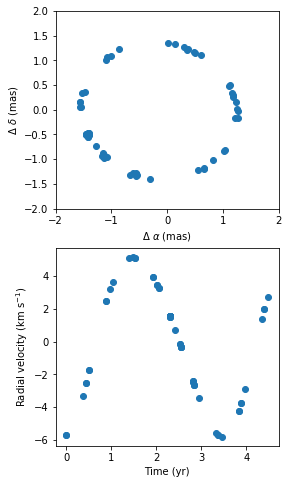

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(4,8))

ax[0].scatter(obs_pos['ra']*3600.0*1.0e3, obs_pos['dec']*3600.0*1.0e3)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_xlabel(r"$\Delta\ \alpha$ (mas)")
ax[0].set_ylabel(r"$\Delta\ \delta$ (mas)")

ax[1].scatter(obs_pos['time']/secyer, obs_pos['rv'])
ax[1].set_xlabel("Time (yr)")
ax[1].set_ylabel("Radial velocity (km s$^{-1}$)")

plt.show()

In [5]:
def plot_pos(p, obs_pos):

    t_tmp = np.linspace(np.min(obs_pos['time']), np.max(obs_pos['time']), 100)

    
    if type(p) is tuple or p.ndim==1:
        rv = orbit.get_RV(p, t_tmp)
        plt.plot(t_tmp/secyer, rv, color='k')
    else: 
        for x in p:
            if len(x)==8:
                p_full = 0.0, 0.0, x[0], x[1], x[2], x[3], 0.0, x[4], x[5], x[6], x[7], 0.0
            else:
                p_full = x
                
            ra, dec = orbit.get_ra_dec(p_full, t_tmp)
            plt.plot(ra*3600.0*1.0e3, dec*3600.0*1.0e3, alpha=0.05, color='k')


    plt.scatter(obs_pos['ra']*3600.0*1.0e3, obs_pos['dec']*3600.0*1.0e3)

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xlabel(r"$\Delta\ \alpha$ (mas)")
    plt.ylabel(r"$\Delta\ \delta$ (mas)")

    plt.show()
    
def plot_pos_ra(p, obs_pos):

    t_tmp = np.linspace(np.min(obs_pos['time']), np.max(obs_pos['time']), 100)

    
    if type(p) is tuple or p.ndim==1:
        ra, dec = orbit.get_ra_dec(p, t_tmp)
        plt.plot(t_tmp/secyer, ra, color='k')
    else: 
        for x in p:
            if len(x)==8:
                p_full = 0.0, 0.0, x[0], x[1], x[2], x[3], 0.0, x[4], x[5], x[6], x[7], 0.0
            else:
                p_full = x
                
            ra, dec = orbit.get_ra_dec(p_full, t_tmp)
            plt.plot(t_tmp/secyer, ra*3600.0*1.0e3, alpha=0.05, color='k')


    plt.scatter(obs_pos['time']/secyer, obs_pos['ra']*3600.0*1.0e3)

    plt.ylim(-2, 2)
    plt.xlabel(r"$\Delta\ \alpha$ (mas)")
    plt.ylabel(r"$\Delta\ \delta$ (mas)")

    plt.show()
    
def plot_pos_dec(p, obs_pos):

    t_tmp = np.linspace(np.min(obs_pos['time']), np.max(obs_pos['time']), 100)

    
    if type(p) is tuple or p.ndim==1:
        ra, dec = orbit.get_ra_dec(p, t_tmp)
        plt.plot(t_tmp/secyer, dec, color='k')
    else: 
        for x in p:
            if len(x)==8:
                p_full = 0.0, 0.0, x[0], x[1], x[2], x[3], 0.0, x[4], x[5], x[6], x[7], 0.0
            else:
                p_full = x
                
            ra, dec = orbit.get_ra_dec(p_full, t_tmp)
            plt.plot(t_tmp/secyer, dec*3600.0*1.0e3, alpha=0.05, color='k')


    plt.scatter(obs_pos['time']/secyer, obs_pos['dec']*3600.0*1.0e3)

    plt.ylim(-2, 2)
    plt.xlabel(r"$\Delta\ \alpha$ (mas)")
    plt.ylabel(r"$\Delta\ \delta$ (mas)")

    plt.show()


def plot_rv(p, obs_pos):

    t_tmp = np.linspace(np.min(obs_pos['time']), np.max(obs_pos['time']), 100)

    
    if type(p) is tuple or p.ndim==1:
        rv = orbit.get_RV(p, t_tmp)
        plt.plot(t_tmp/secyer, rv, color='k')
    else: 
        for x in p:
            if len(x)==8:
                p_full = 0.0, 0.0, x[0], x[1], x[2], x[3], 0.0, x[4], x[5], x[6], x[7], 0.0
            else:
                p_full = x
                
            rv = orbit.get_RV(p_full, t_tmp)
            plt.plot(t_tmp/secyer, rv, alpha=0.05, color='k')


    plt.scatter(obs_pos['time']/secyer, obs_pos['rv'])
    plt.xlabel("Time (yr)")
    plt.ylabel("Radial velocity (km s$^{-1}$)")

    plt.show()

### Let's first try to fit the orbital period

In [8]:
model = LombScargleFast().fit(obs_pos['time'], obs_pos['rv'], obs_pos['rv_err'])
periods, power = model.periodogram_auto(nyquist_factor=100)

# Get highest power period
best_period = periods[np.argmax(power)]

### Let's try to first fit the RV curve

-188.006021478
(0.0, 0.0, array([ 1.39963492]), array([ 1.87488225]), array([ 0.19087164]), array([ 88191929.41483378]), 0.0, array([  1.15080362e+08]), array([ 0.12748309]), array([  2.21848241e+33]), array([  1.52910964e+34]), 0.0)


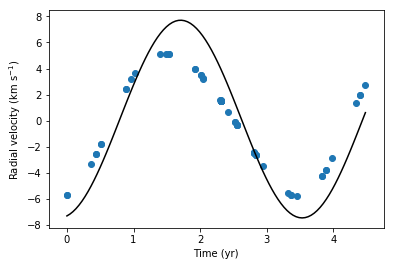

In [20]:
ll_best = -100000.0
Omega_best = -1
omega_best = -1
I_best = -1
e_best = -1
P_best = -1
tau_best = -1
gamma_best = -1
M1_best = -1
M2_best = -1

obs_time = np.max(obs_pos['time']) - np.min(obs_pos['time'])


for i in range(1000):

    Omega_test = np.random.uniform(0.0, 2.0*np.pi, size=1) # omega
    omega_test = np.random.uniform(0.0, 2.0*np.pi, size=1) # omega
    I_test = np.random.uniform(0.0, np.pi, size=1) # I
#     e_test = np.random.uniform(0.0, 1.0, size=1) # e
    P_test = np.random.normal(loc=best_period, scale=0.1*best_period, size=1)
#     P_test = np.random.uniform(obs_time/100.0, obs_time, size=1) # P
    tau_test = np.random.uniform(0.0, P_test, size=1)
#     tau_test = np.random.uniform(np.min(obs_pos['time']), np.min(obs_pos['time'])+P_test, size=1)
    gamma_test = np.random.uniform(np.min(obs_pos['rv']), np.max(obs_pos['rv']), size=1) # gamma
    M1_test = Msun*np.random.uniform(0.1, 10.0, size=1) # M1
    M2_test = Msun*np.random.uniform(0.1, 10.0, size=1) # M2

    p = 0.0, 0.0, Omega_test, omega_test, I_test, tau_test, 0.0, P_test, gamma_test, M1_test, M2_test, 0.0
    ll_test = prob.ln_likelihood_rv(p, obs_pos)
                
    if ll_test > ll_best:
        ll_best = ll_test
        
        Omega_best = Omega_test
        omega_best = omega_test
        I_best = I_test
#         e_best = e_test
        P_best = P_test
        tau_best = tau_test
        gamma_best = gamma_test
        M1_best = M1_test
        M2_best = M2_test
        
        
print(ll_best)

p_best = 0.0, 0.0, Omega_best, omega_best, I_best, tau_best, 0.0, P_best, gamma_best, M1_best, M2_best, 0.0
print(p_best)

plot_rv(p_best, obs_pos)

### Now, let's run a minimizer

True [  1.39963492e+00   2.11056282e+00   1.36035609e-01   8.81919294e+07
   1.15080362e+08   1.77841687e-02   2.21848241e+33   1.52910964e+34]


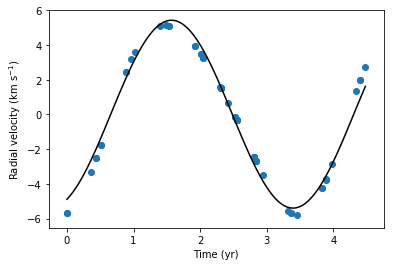

In [21]:
def prob_wrapper(x, obs_pos):
    
    Omega, omega, I, tau, P, gamma, M1, M2 = x
    p = 0.0, 0.0, Omega, omega, I, tau, 0.0, P, gamma, M1, M2, 0.0
        
    return -prob.ln_likelihood_rv(p, obs_pos)


bounds = ((0.0, 2.0*np.pi), (0.0, 2.0*np.pi), (0.0, np.pi), (0.0,1.0e9),  
          (1.0e4,1.0e10), (-1000.0,1000.0), 
          (0.1*Msun,10.0*Msun), (0.1*Msun,10.0*Msun))
x0 = Omega_best, omega_best, I_best, tau_best, P_best, gamma_best, M1_best, M2_best
# sol = minimize(prob_wrapper, x0, args=(obs_pos,), method='TNC', bounds=bounds)
sol = minimize(prob_wrapper, x0, args=(obs_pos,), method='SLSQP', bounds=bounds)
# sol = minimize(prob_wrapper, x0, args=(obs_pos,))


print(sol.success, sol.x)
if (sol.x[0]> 2.0*np.pi): sol.x[0] = 1.9*np.pi
if (sol.x[1]> 2.0*np.pi): sol.x[1] = 1.9*np.pi
p_sol = 0.0, 0.0, sol.x[0], sol.x[1], sol.x[2], sol.x[3], 0.0, sol.x[4], sol.x[5], sol.x[6], sol.x[7], 0.0
plot_rv(p_sol, obs_pos)

### Now, run emcee

Acceptance fraction:
[ 0.455  0.465  0.435  0.5    0.445  0.495  0.445  0.52   0.555  0.42
  0.385  0.455  0.49   0.36   0.43   0.515  0.415  0.465  0.5    0.445
  0.415  0.43   0.53   0.39   0.455  0.44   0.475  0.475  0.475  0.405
  0.46   0.47   0.46   0.455  0.49   0.42   0.525  0.46   0.455  0.48   0.47
  0.46   0.425  0.455  0.5    0.46   0.515  0.49   0.475  0.4    0.485
  0.42   0.37   0.465  0.455  0.47   0.405  0.435  0.465  0.5    0.46
  0.475  0.48   0.435  0.475  0.425  0.42   0.43   0.44   0.42   0.475
  0.475  0.465  0.465  0.425  0.455  0.45   0.525  0.48   0.435  0.35   0.47
  0.475  0.44   0.385  0.495  0.485  0.425  0.41   0.445  0.41   0.43
  0.455  0.43   0.465  0.5    0.41   0.435  0.41   0.455]


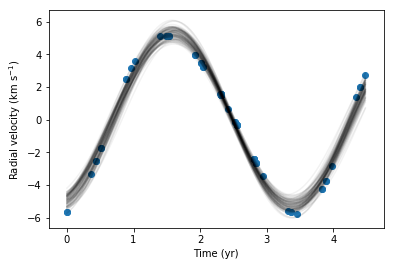

In [22]:
def ln_posterior(x, obs_pos):

    Omega, omega, I, tau, P, gamma, M1, M2 = x

    ll = 0.0
    
    #### Priors ####

    if Omega < 0. or Omega > 2.0*np.pi: return -np.inf
    if omega < 0. or omega > 2.0*np.pi: return -np.inf

    # Needs to discern between left-handed and right-handed
    if I < 0.0 or I > np.pi: return -np.inf

    # Zero point needs to be constrained to first orbital period
    if tau < 0.0 or tau > P: return -np.inf
    
    # Eccentricity keeps the system bound
#     if e < 0. or e > 1.0: return -np.inf
    
    # Period
    if P < 1.0e4 or P > 1.0e10: return -np.inf
    
    # Gamma
    if gamma < -1000.0 or gamma > 1000.0: return -np.inf
    
    # Constrain mass around 1 Msun
    if M1 < 0.1*Msun or M1 > 10.0*Msun: return -np.inf
    if M2 < 0.1*Msun or M2 > 10.0*Msun: return -np.inf

    # Add priors to preference lower masses
    ll = ll - 2.35*np.log(M1) - 2.35*np.log(M2)
    
    
    ### Likelihood ####
    p = 0.0, 0.0, Omega, omega, I, tau, 0.0, P, gamma, M1, M2, 0.0
    
    ll = ll + prob.ln_likelihood_rv(p, obs_pos)
    
    return ll


    


nwalkers = 100
ndim = 8

# Initialize walkers
p0 = np.zeros((nwalkers,ndim))
p0[:,0] = sol.x[0] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # Omega
p0[:,1] = sol.x[1] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # omega
p0[:,2] = sol.x[2] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # I
p0[:,3] = sol.x[3] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # tau
# p0[:,4] = sol.x[4] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # e
p0[:,4] = sol.x[4] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # P
p0[:,5] = sol.x[5] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # gamma
p0[:,6] = sol.x[6] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # M1
p0[:,7] = sol.x[7] * (1.0 + np.random.normal(0.0, 0.001, size=nwalkers)) # M2

    
# Run emcee
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=(obs_pos,))
sampler.run_mcmc(p0, N=100)
pos,ln_prob,state = sampler.run_mcmc(p0, N=100)

print("Acceptance fraction:")
print(sampler.acceptance_fraction)

plot_rv(pos, obs_pos)

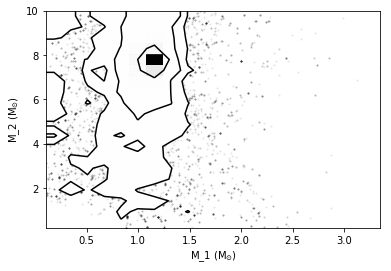

In [23]:
corner.hist2d(sampler.flatchain[:,6]/Msun, sampler.flatchain[:,7]/Msun)

plt.xlabel(r"M_1 (M$_{\odot}$)")
plt.ylabel(r"M_2 (M$_{\odot}$)")

plt.show()

### Extend model to all 12 orbital parameters

In [11]:
# Prior on parameters
def ln_prior(p):

    sys_ra, sys_dec, Omega, omega, I, tau, e, P, gamma, M1, M2, distance = p

    lp = 0.

    # Angles bound between 0 and 2pi
    if Omega < 0. or Omega > 2.0*np.pi:
        return -np.inf
    if omega < 0. or omega > 2.0*np.pi:
        return -np.inf

    # Needs to discern between left-handed and right-handed
    if I < 0. or I > np.pi:
        return -np.inf

    # Zero point needs to be constrained to first orbital period
    if tau < 0. or tau > P:
        return -np.inf

    # Eccentricity keeps the system bound
    if e < 0. or e > 1.0:
        return -np.inf

    # Period
    if P < 1.0e4 or P > 1.0e10:
        return -np.inf

    # Gamma
    if gamma < -1000.0 or gamma > 1000.0:
        return -np.inf
    # Prior to push gamma closer to zero
    lp = lp - (gamma/5.0)**2

    # Constrain mass around 1 Msun
    if M1 < 0.1*Msun or M1 > 100.0*Msun:
        return -np.inf
    if M2 < 0.1*Msun or M2 > 100.0*Msun:
        return -np.inf
    
    # Prior on inclination angle
    lp = lp + np.log(np.sin(I)/2.0)

    # Prior on distance
    if distance < 1.0 or distance > 10000.0:
        return -np.inf

    return lp

def ln_posterior(p, obs_pos):


    # Check prior on model first
    lp = ln_prior(p)
    
    if np.isnan(lp) or np.isinf(lp):
        return -np.inf

    # Then check likelihood of parameters
    ll = 0.0
    ll = ll + prob.ln_likelihood_pos(p, obs_pos)
    ll = ll + prob.ln_likelihood_plx(p, obs_pos)

    
    if np.any(np.isnan(ll) | np.isinf(ll)):
        return -np.inf

    if np.all(ll == 0.):
        return -np.inf

    return lp + ll.sum()

In [16]:
ndim = 12

# initial positions for walkers
p0 = np.zeros((nwalkers,ndim))


# Some initial test values
ra_initial = np.mean(obs_pos['ra'])
dec_initial = np.mean(obs_pos['dec'])
e_initial = 0.1

for i in range(nwalkers):

    ll_best = -1000000
    
    for j in range(100):

        # Get the orbital separation implied by the masses and orbital period
#         orbital_separation = orbit.P_to_a(pos[i,6], pos[i,7], pos[i,4])
#         angular_separation = np.max([np.max(obs_pos['ra'])-np.min(obs_pos['ra']), 
#                                      np.max(obs_pos['dec'])-np.min(obs_pos['dec'])])
#         distance_initial = orbital_separation / (angular_separation*3600.0) # Get distance estimate in pc
        distance_initial = 1.0e3/obs_pos['plx'][0]
                
        ra_test = ra_initial + np.random.normal(0.0, 1.0e-8, size=1) # RA
        dec_test = dec_initial + np.random.normal(0.0, 1.0e-8, size=1) # Dec
        Omega_test = pos[i,0] # Omega
        omega_test = pos[i,1]  # omega
        I_test = pos[i,2]  # I
        tau_test = pos[i,3]
        e_test = e_initial + np.random.normal(0.0, 0.01, size=1) # e
        P_test = pos[i,4]
        gamma_test = pos[i,5]
        M1_test = pos[i,6]
        M2_test = pos[i,7]
        distance_test = distance_initial * (1.0 + np.random.uniform(0.0, 0.1, size=1))  # distance

        p0_test = ra_test, dec_test, pos[i,0], pos[i,1], pos[i,2], \
            pos[i,3], e_test, pos[i,4], pos[i,5], pos[i,6], pos[i,7], distance_test

        if j==0: p0_best = p0_test
            
        ll_test = ln_posterior(p0_test, obs_pos)
        
        if np.isnan(ll_test): continue
#         print(i, p0_test, ll_test)
        
        if ll_test > ll_best:
            ll_best = ll_test
            p0_best = p0_test
        
        
    print(i, ll_best)
    p0[i] = p0_best


0 -1000000
1 -1000000
2 -1000000
3 -1000000
4 -1000000
5 -1000000
6 -1000000
7 -1000000
8 -1000000
9 -1000000
10 -1000000


KeyboardInterrupt: 

### Select best point and move all other walkers near that one

In [13]:

# Find best walker

ll_best = -1000000
i_best = -1

for i in range(nwalkers):
    ll_walker = ln_posterior(p0[i], obs_pos)
    
    if ll_walker > ll_best:
        i_best = i
        ll_best = ll_walker
        p0_best = p0[i]
        
print(i_best, ll_best)


# Move all other walkers near this one
for i in range(nwalkers):
    for j in range(ndim):
        p0[i,j] = p0_best[j] * (1.0 + np.random.normal(0.0, 0.01, size=1))
        
    ll_walker = ln_posterior(p0[i], obs_pos)
    print(i, ll_walker)

55 -3197.39586791
0 -3193.56312427
1 -3403.28008067
2 -3086.00965578
3 -3547.40467928
4 -2639.66404089
5 -3370.24974158
6 -3631.41075825
7 -3737.20600815
8 -3329.46723101
9 -3694.3454978
10 -2977.00798969
11 -2790.9119487
12 -3796.77556359
13 -3259.24927327
14 -3527.5991039
15 -4218.20695524
16 -3196.62611466
17 -4067.15530089
18 -3301.34048762
19 -3728.28124048
20 -3390.82774647
21 -2927.03782144
22 -3088.33551972
23 -3152.24513239
24 -2780.98240547
25 -4297.93961251
26 -3523.25378534
27 -2530.10019499
28 -2774.00629585
29 -3183.31907516
30 -3191.06224695
31 -3374.22030235
32 -3887.3847905
33 -2508.01801934
34 -4411.578
35 -3287.47414403
36 -2897.50920172
37 -3308.82597265
38 -3421.86634754
39 -3171.25896426
40 -2569.58851564
41 -3335.81586664
42 -3040.88485306
43 -2547.13379928
44 -2826.57811929
45 -3012.8231387
46 -3478.39974263
47 -3428.19609036
48 -3398.23264117
49 -2758.36306222
50 -3081.03756601
51 -3282.5728296
52 -3250.41075931
53 -2759.3041483
54 -2656.94104769
55 -3846.20317

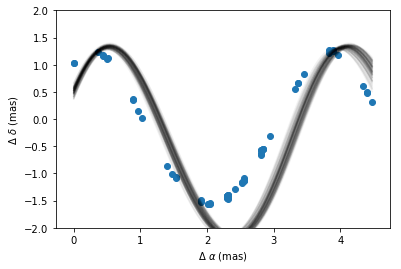

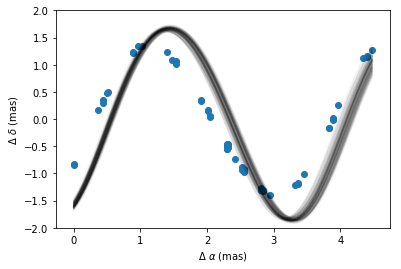

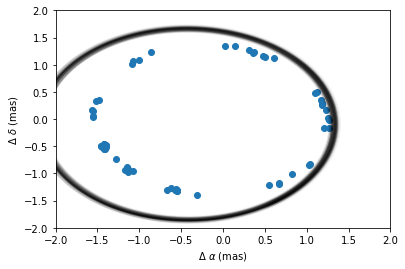

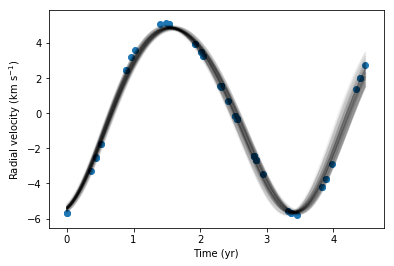

In [14]:
plot_pos_ra(p0, obs_pos)

plot_pos_dec(p0, obs_pos)

plot_pos(p0, obs_pos)

plot_rv(p0, obs_pos)

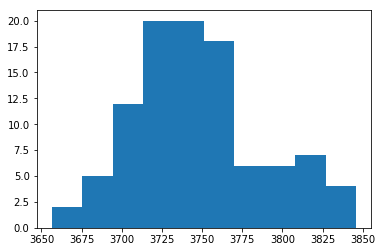

In [15]:
plt.hist(p0[:,11])
plt.show()

### Run without RVs

In [63]:
# Run emcee
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=(obs_pos,))
pos,ln_prob,state = sampler.run_mcmc(p0, N=100)

print("Acceptance fraction:")
print(sampler.acceptance_fraction)


Acceptance fraction:
[ 0.38  0.38  0.4   0.38  0.45  0.34  0.43  0.42  0.42  0.43  0.36  0.39
  0.39  0.37  0.38  0.39  0.37  0.39  0.32  0.35  0.47  0.37  0.33  0.37
  0.43  0.47  0.39  0.45  0.49  0.39  0.46  0.39  0.3   0.32  0.45  0.44
  0.4   0.39  0.44  0.36  0.38  0.37  0.45  0.42  0.34  0.41  0.39  0.36
  0.4   0.43  0.51  0.44  0.5   0.41  0.37  0.45  0.4   0.43  0.35  0.39
  0.4   0.41  0.38  0.45  0.38  0.44  0.48  0.36  0.49  0.41  0.47  0.39
  0.42  0.35  0.45  0.36  0.4   0.46  0.32  0.41  0.4   0.36  0.43  0.42
  0.35  0.36  0.38  0.4   0.35  0.4   0.41  0.34  0.42  0.48  0.35  0.4
  0.46  0.43  0.35  0.43]


In [73]:
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=(obs_pos,))
pos,ln_prob,state = sampler.run_mcmc(pos, N=1000)

print("Acceptance fraction:")
print(sampler.acceptance_fraction)

Acceptance fraction:
[ 0.176  0.103  0.176  0.082  0.044  0.105  0.185  0.186  0.101  0.162
  0.085  0.125  0.081  0.184  0.177  0.194  0.2    0.048  0.036  0.099
  0.175  0.178  0.149  0.119  0.089  0.116  0.163  0.106  0.185  0.192
  0.173  0.177  0.117  0.161  0.174  0.121  0.179  0.158  0.168  0.091
  0.063  0.162  0.068  0.098  0.171  0.117  0.173  0.106  0.081  0.111
  0.124  0.19   0.102  0.161  0.176  0.069  0.144  0.175  0.153  0.115
  0.102  0.167  0.174  0.187  0.191  0.084  0.15   0.153  0.071  0.076
  0.197  0.165  0.187  0.102  0.068  0.164  0.191  0.194  0.066  0.17
  0.183  0.081  0.179  0.189  0.124  0.195  0.115  0.164  0.165  0.084
  0.068  0.191  0.169  0.197  0.141  0.083  0.093  0.106  0.07   0.083]


In [36]:
def ln_posterior(p, obs_pos):


    # Check prior on model first
    lp = prob.ln_prior(p)

    if np.isnan(lp) or np.isinf(lp):
        return -np.inf

    # Then check likelihood of parameters
    ll = 0.0
#     ll = ll + ln_likelihood_rv(p, obs_pos)
    ll = ll + prob.ln_likelihood_pos(p, obs_pos)

    if np.any(np.isnan(ll) | np.isinf(ll)):
        return -np.inf

    if np.all(ll == 0.):
        return -np.inf

    return lp + ll.sum()

# sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=(obs_pos,))

sampler.reset()
pos,ln_prob,state = sampler.run_mcmc(pos, N=100)
print(sampler.acceptance_fraction)

/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/jeffandrews/anaconda3/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


[ 0.33  0.38  0.37  0.36  0.46  0.34  0.26  0.3   0.43  0.43  0.4   0.4
  0.41  0.4   0.42  0.44  0.    0.37  0.32  0.38  0.36  0.42  0.4   0.
  0.38  0.31  0.26  0.35  0.42  0.38  0.32  0.37  0.33  0.39  0.39  0.33
  0.38  0.42  0.36  0.35  0.43  0.44  0.42  0.38  0.38  0.38  0.    0.32
  0.32  0.45  0.29  0.36  0.34  0.36  0.35  0.31  0.43  0.32  0.37  0.37
  0.44  0.4   0.33  0.38  0.43  0.34  0.38  0.24  0.41  0.4   0.31  0.27
  0.33  0.41  0.32  0.33  0.34  0.39  0.31  0.33  0.34  0.37  0.43  0.28
  0.29  0.5   0.4   0.24  0.32  0.34  0.38  0.4   0.3   0.35  0.4   0.4
  0.33  0.42  0.35  0.41]


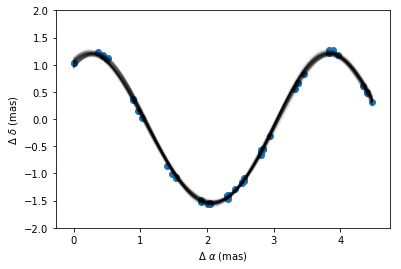

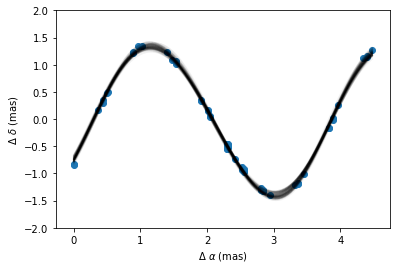

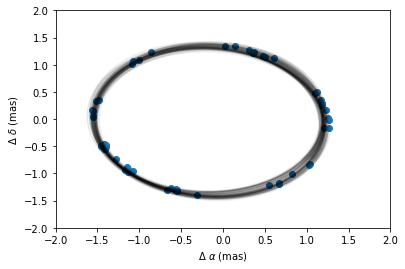

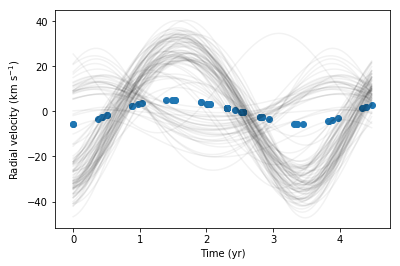

In [75]:
plot_pos_ra(pos, obs_pos)

plot_pos_dec(pos, obs_pos)

plot_pos(pos, obs_pos)

plot_rv(pos, obs_pos)

### Plot constraints

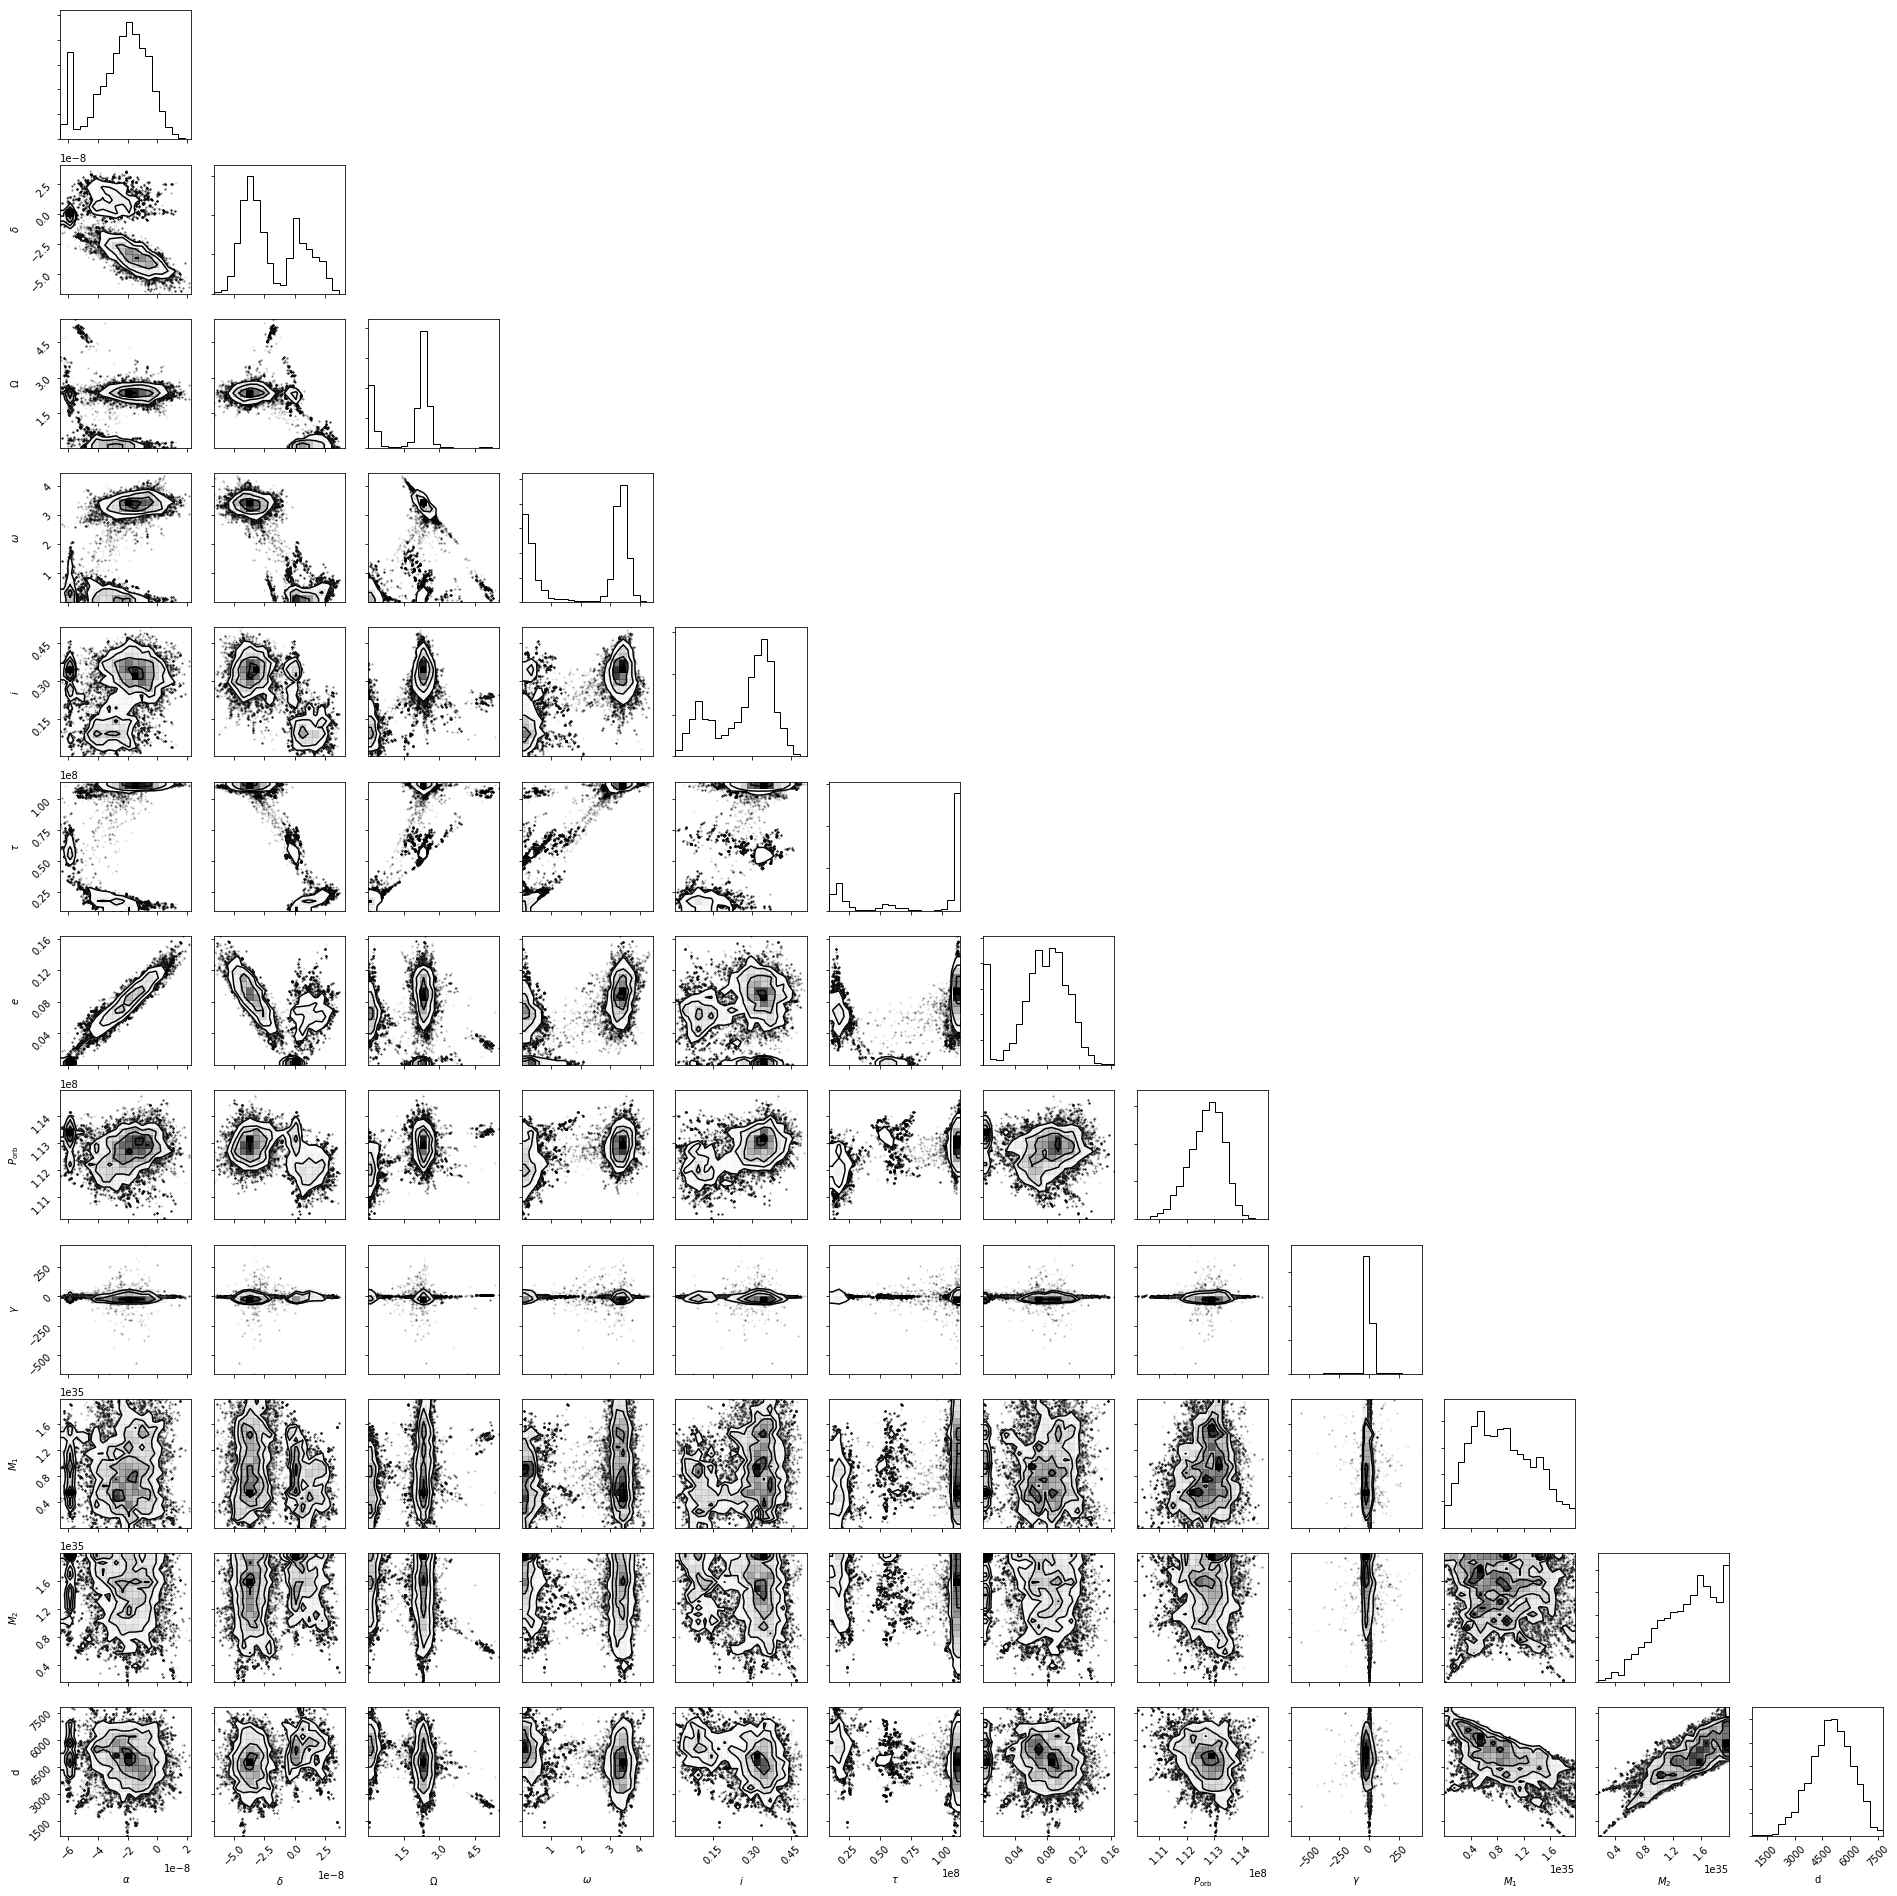

In [77]:
labels = [r"$\alpha$", r"$\delta$", r"$\Omega$", r"$\omega$", r"$i$", r"$\tau$", 
          r"$e$", r"$P_{\rm orb}$", r"$\gamma$", r"$M_1$", r"$M_2$", r"d"]
fig = corner.corner(sampler.flatchain, labels=labels)

plt.tight_layout()
plt.savefig("../figures/noRV_corner.pdf")
# plt.show()

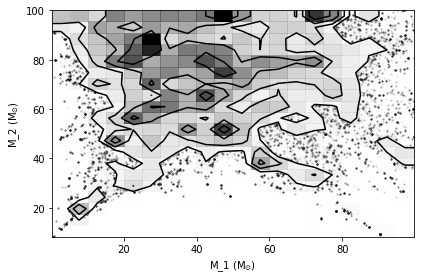

In [124]:
corner.hist2d(sampler.flatchain[:,9]/Msun, sampler.flatchain[:,10]/Msun)

plt.xlabel(r"M_1 (M$_{\odot}$)")
plt.ylabel(r"M_2 (M$_{\odot}$)")

plt.tight_layout()
plt.savefig("../figures/noRV_M1_M2.pdf")

# plt.show()

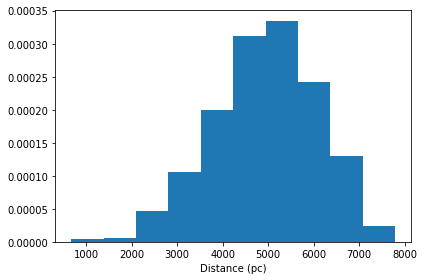

In [125]:
plt.hist(sampler.flatchain[:,11], normed=True)
plt.xlabel("Distance (pc)")

plt.tight_layout()
plt.savefig("../figures/noRV_distance.pdf")

### Run with RVs

In [134]:
# for i in range(nwalkers):
#     print(ln_posterior_rv(pos_rv[i], obs_pos))

In [173]:
sampler_rv = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior_rv, args=(obs_pos,))
pos_rv,ln_prob_rv,state_rv = sampler_rv.run_mcmc(pos_rv, N=1000)
print(sampler_rv.acceptance_fraction)

[ 0.251  0.315  0.268  0.27   0.305  0.112  0.229  0.24   0.225  0.272
  0.199  0.248  0.271  0.301  0.286  0.34   0.243  0.307  0.302  0.308
  0.304  0.242  0.282  0.077  0.316  0.248  0.286  0.292  0.091  0.304
  0.306  0.26   0.274  0.087  0.289  0.295  0.318  0.035  0.288  0.296
  0.307  0.28   0.262  0.286  0.255  0.25   0.217  0.274  0.092  0.216
  0.28   0.265  0.312  0.241  0.31   0.271  0.105  0.287  0.204  0.295
  0.29   0.261  0.122  0.256  0.292  0.265  0.304  0.05   0.291  0.272
  0.266  0.246  0.268  0.248  0.284  0.096  0.294  0.284  0.299  0.259
  0.096  0.296  0.278  0.299  0.293  0.285  0.321  0.16   0.249  0.203
  0.287  0.307  0.238  0.252  0.293  0.28   0.246  0.273  0.275  0.29 ]


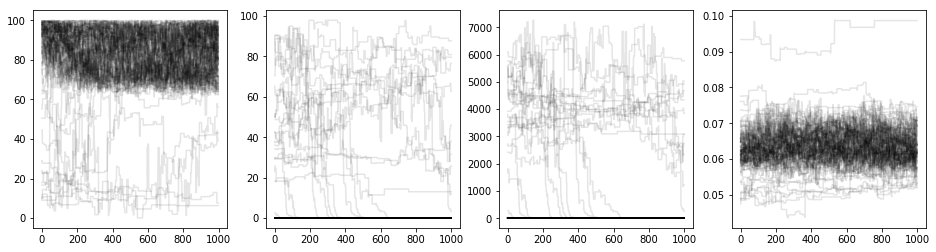

In [174]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i in range(nwalkers):  ax[0].plot(sampler_rv.chain[i,:,9]/Msun, alpha=0.1, color='k') # M1
for i in range(nwalkers):  ax[1].plot(sampler_rv.chain[i,:,10]/Msun, alpha=0.1, color='k') # M2
for i in range(nwalkers):  ax[2].plot(sampler_rv.chain[i,:,11], alpha=0.1, color='k') # Distance
for i in range(nwalkers):  ax[3].plot(sampler_rv.chain[i,:,4], alpha=0.1, color='k') # I
    
plt.show()

In [179]:
# Store solutions

sampler_rv_solution1 = sampler_rv

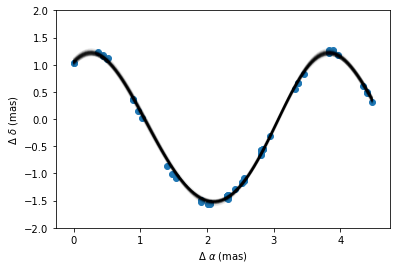

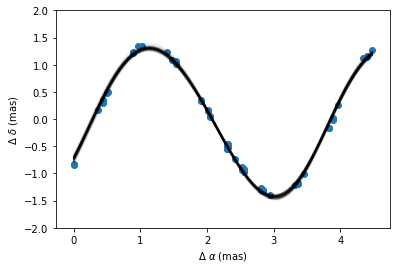

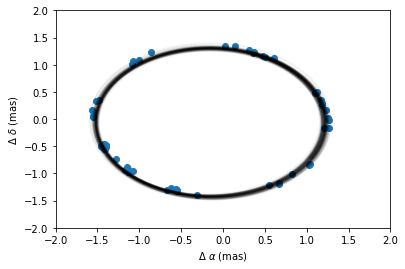

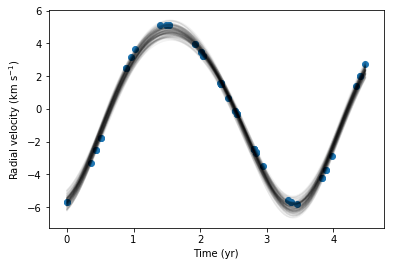

In [175]:
plot_pos_ra(pos_rv, obs_pos)

plot_pos_dec(pos_rv, obs_pos)

plot_pos(pos_rv, obs_pos)

plot_rv(pos_rv, obs_pos)

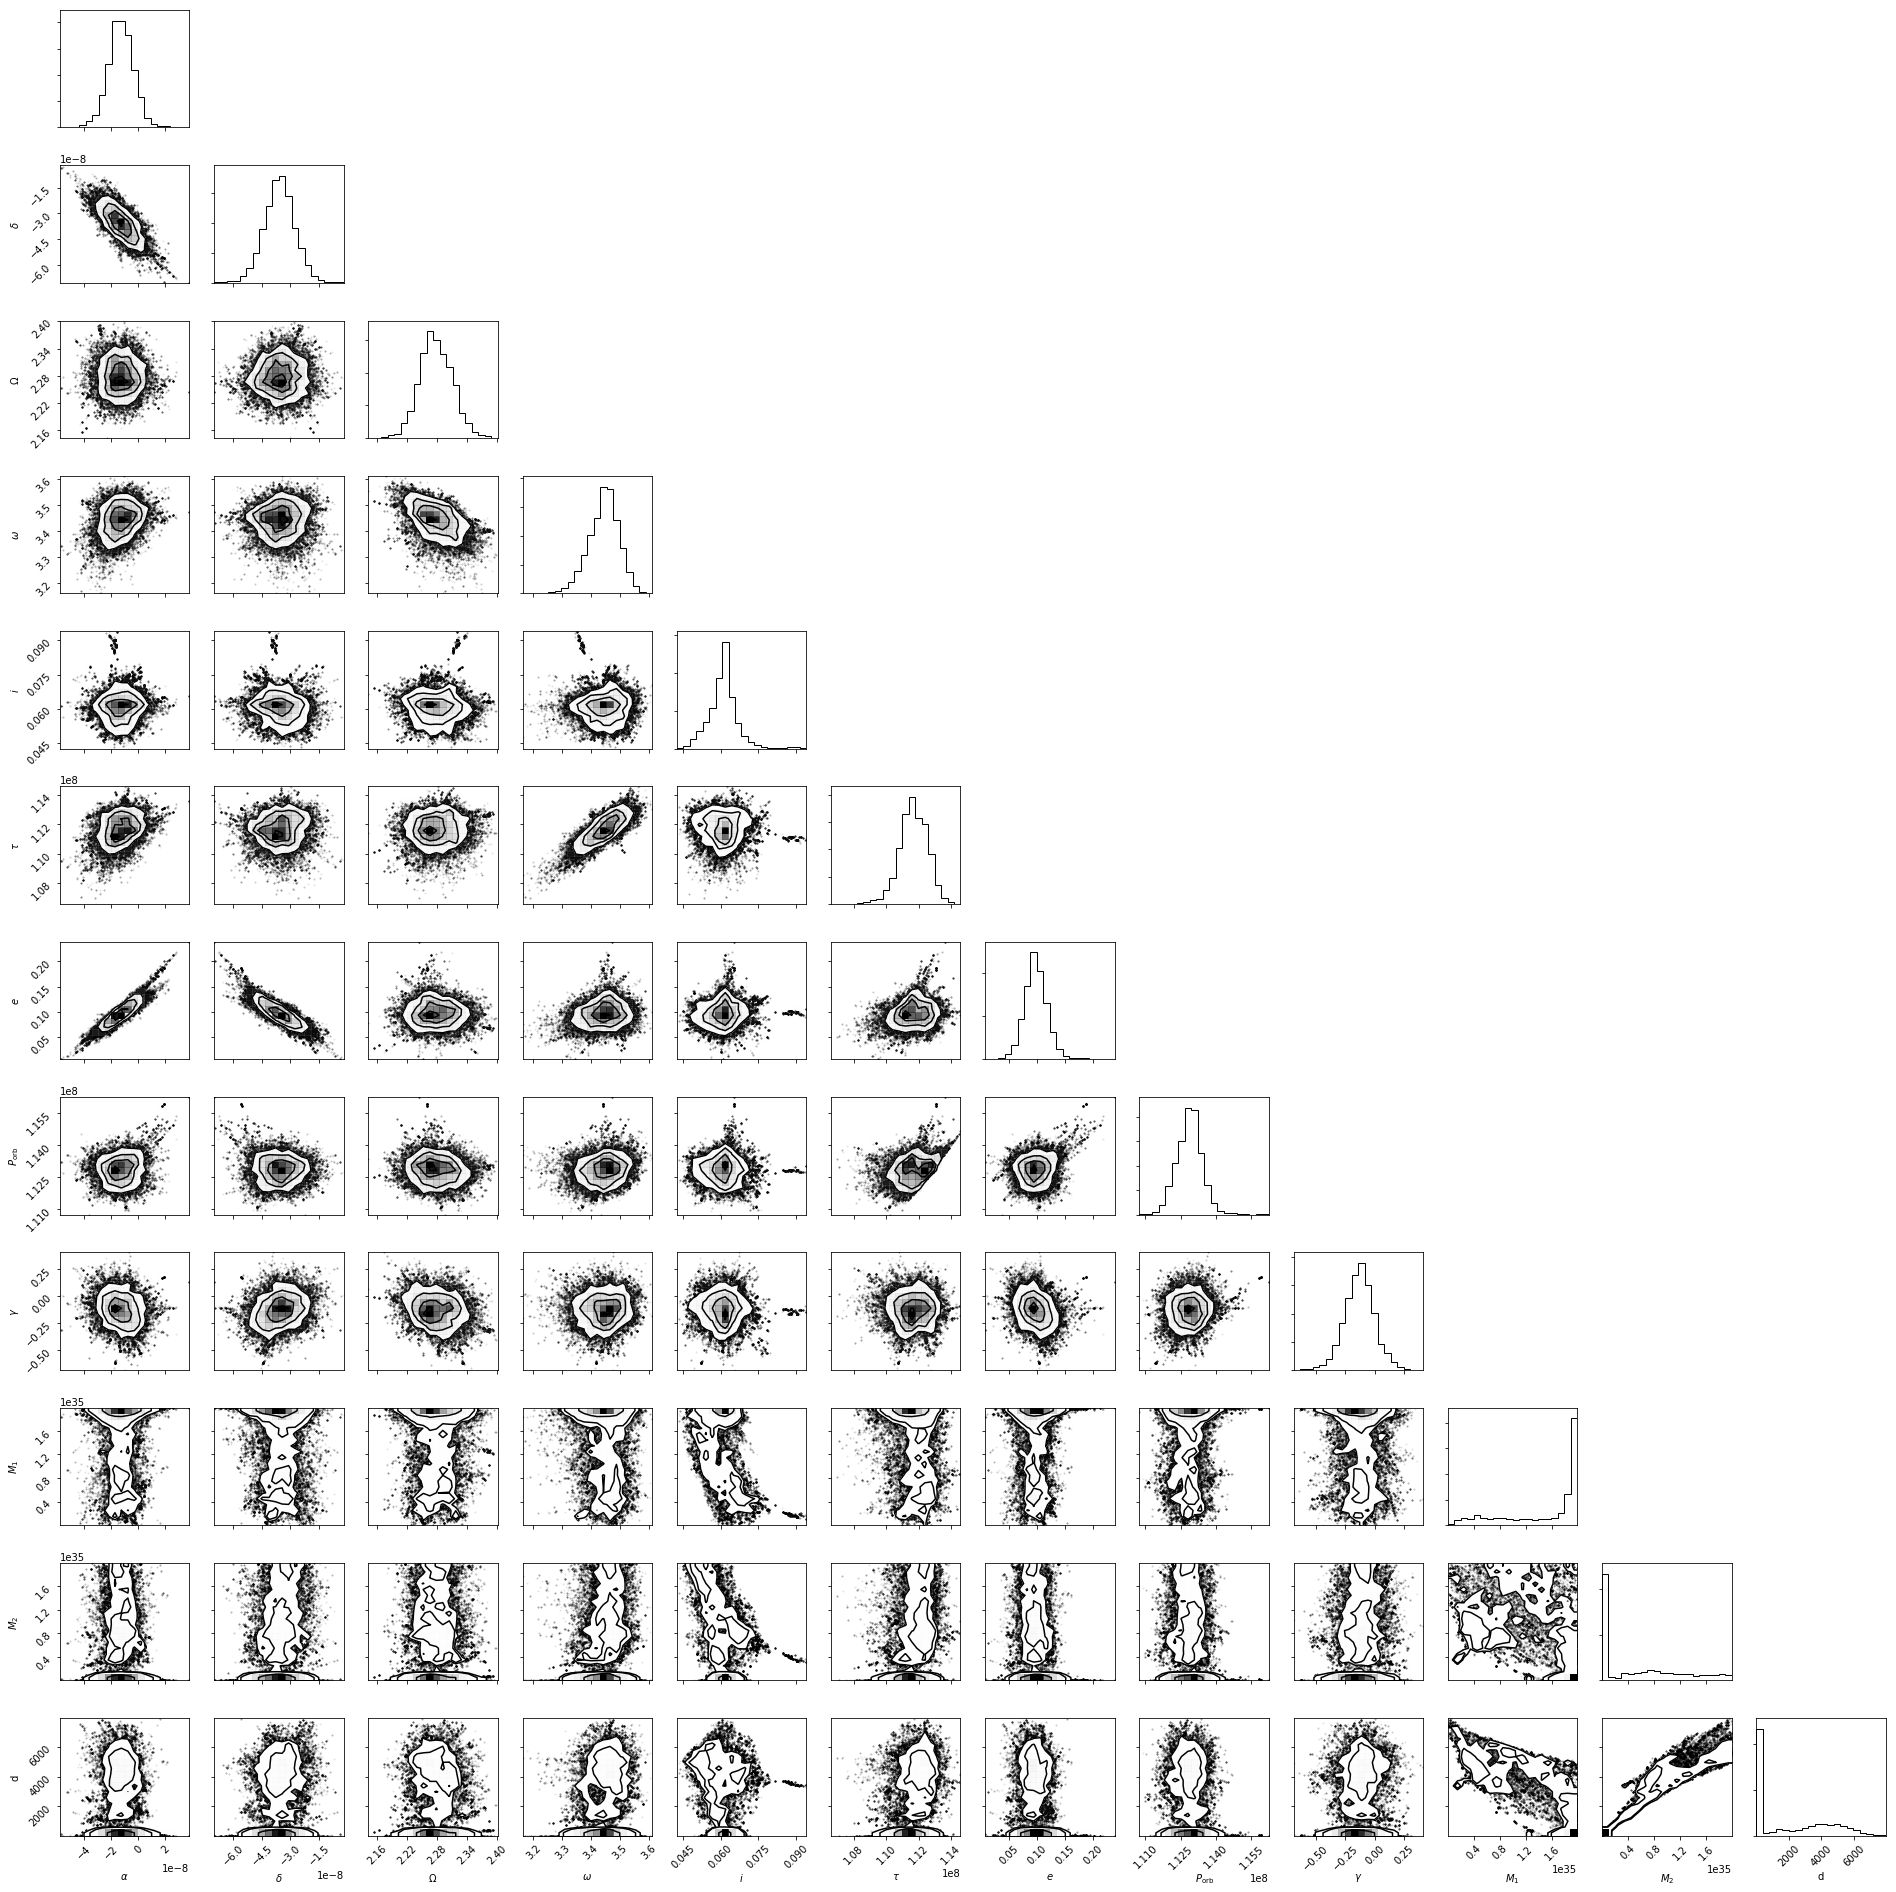

In [172]:
labels = [r"$\alpha$", r"$\delta$", r"$\Omega$", r"$\omega$", r"$i$", r"$\tau$", 
          r"$e$", r"$P_{\rm orb}$", r"$\gamma$", r"$M_1$", r"$M_2$", r"d"]
fig = corner.corner(sampler_rv.flatchain, labels=labels)

plt.tight_layout()
# plt.savefig("../figures/RV_corner.pdf")
plt.show()

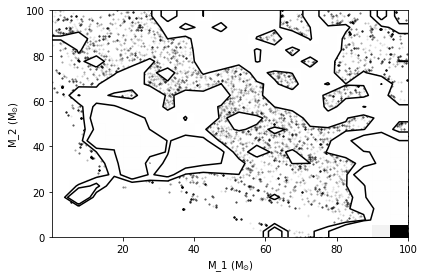

In [149]:
corner.hist2d(sampler_rv.flatchain[:,9]/Msun, sampler_rv.flatchain[:,10]/Msun, bins=20)

plt.xlabel(r"M_1 (M$_{\odot}$)")
plt.ylabel(r"M_2 (M$_{\odot}$)")

plt.tight_layout()
plt.savefig("../figures/RV_M1_M2.pdf")
# plt.show()

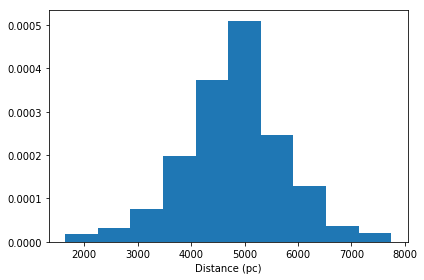

In [123]:
plt.hist(sampler_rv.flatchain[:,11], normed=True)
plt.xlabel("Distance (pc)")

plt.tight_layout()
plt.savefig("../figures/RV_distance.pdf")

In [105]:

# Find best walker

ll_best = -1000000
i_best = -1

for i in range(nwalkers):
    ll_walker = prob.ln_posterior(pos_rv[i], obs_pos)
    
    if ll_walker > ll_best:
        i_best = i
        ll_best = ll_walker
        p0_best = pos_rv[i]
        
print(i_best, ll_best)
print(p0_best)


# Move all other walkers near this one
p0_rv = np.zeros((nwalkers, ndim))
for i in range(nwalkers):
    for j in range(ndim):
        p0_rv[i,j] = p0_best[j] * (1.0 + np.random.normal(0.0, 0.0001, size=1))
        
    ll_walker = prob.ln_posterior(p0_rv[i], obs_pos)
    print(i, ll_walker)

61 94.9349411959
[ -1.29850620e-08  -3.00744183e-08   2.26131542e+00   3.51246451e+00
   6.16340314e-02   1.12914788e+08   9.04936637e-02   1.13083687e+08
  -1.44024292e-01   9.13898084e+34   1.24454316e+35   4.69657882e+03]
0 94.9575862923
1 94.9608773337
2 94.9269538468
3 94.9687740086
4 94.7654382462
5 94.8801837581
6 94.8751940844
7 94.9336239148
8 94.898941327
9 94.9626629602
10 94.9174594471
11 94.9784236014
12 94.9369276541
13 94.9914321492
14 94.9365518825
15 94.9595053874
16 94.8787156779
17 94.8677047428
18 94.9310983475
19 95.0007232684
20 95.0714598349
21 95.0238619165
22 94.9326404117
23 95.0126441535
24 94.9170063401
25 94.9131448213
26 94.9408925392
27 94.9922128832
28 94.9589930364
29 94.9174969287
30 94.9059530314
31 94.891794416
32 94.8628100532
33 94.9494745865
34 94.8169490413
35 94.9543776539
36 94.9145859634
37 94.9657522153
38 94.9798072676
39 94.9481542681
40 94.9735182998
41 94.8461428762
42 94.9059512189
43 94.9505494826
44 94.9221375693
45 94.9753023001
46 94

In [119]:
sampler_rv = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=prob.ln_posterior, args=(obs_pos,))
pos_rv_2,ln_prob_rv,state_rv = sampler_rv.run_mcmc(pos_rv_2, N=200)
print(sampler_rv.acceptance_fraction)

[ 0.3    0.315  0.315  0.23   0.285  0.33   0.315  0.29   0.375  0.285
  0.405  0.3    0.325  0.335  0.335  0.36   0.325  0.365  0.37   0.31
  0.225  0.295  0.315  0.295  0.35   0.29   0.25   0.34   0.345  0.315
  0.355  0.385  0.3    0.26   0.365  0.315  0.375  0.16   0.375  0.325
  0.365  0.31   0.31   0.285  0.31   0.385  0.385  0.315  0.285  0.3    0.275
  0.295  0.275  0.335  0.28   0.215  0.3    0.29   0.27   0.335  0.23   0.29
  0.295  0.295  0.32   0.31   0.34   0.28   0.28   0.315  0.405  0.21   0.28
  0.29   0.275  0.285  0.22   0.26   0.16   0.33   0.16   0.245  0.155
  0.265  0.255  0.255  0.19   0.35   0.29   0.235  0.26   0.3    0.3    0.305
  0.24   0.175  0.28   0.32   0.295  0.245]


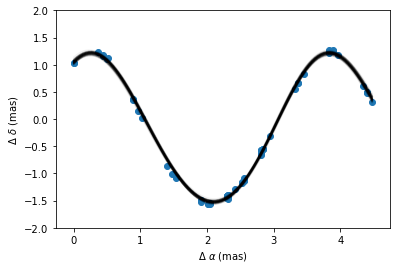

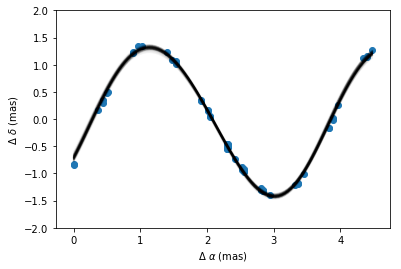

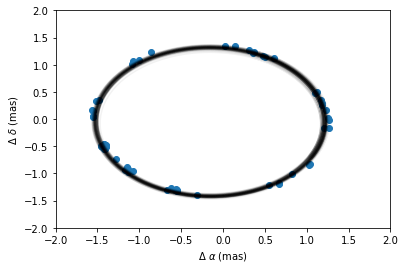

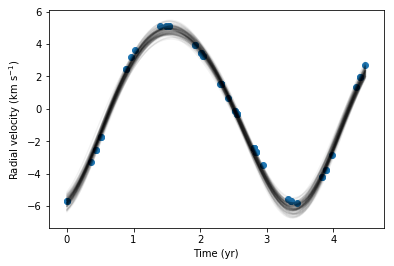

In [116]:
plot_pos_ra(pos_rv_2, obs_pos)

plot_pos_dec(pos_rv_2, obs_pos)

plot_pos(pos_rv_2, obs_pos)

plot_rv(pos_rv_2, obs_pos)

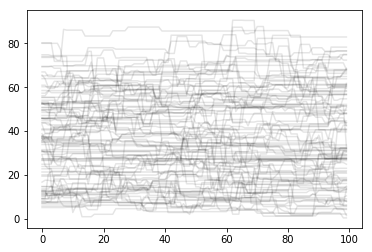

In [137]:
for i in range(nwalkers):
    plt.plot(sampler_rv.chain[i,:,9]/Msun, alpha=0.1, color='k')
    
plt.show()

In [112]:
print(sampler_rv.chain.shape)

(100, 100, 12)
